In [29]:
# Import Libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Import Dataset
df = pd.read_csv('dataset.csv')

# Preprocess and Vectorize Text Data
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X = tfidf_vectorizer.fit_transform(df['posts'])
y = df['type']

# Split into Training and Test sets with a smaller training size
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.2, random_state=42)

# Initialize and train the Random Forest Classifier with fewer trees and parallel processing
random_forest_model = RandomForestClassifier(n_estimators=1000, random_state=42, n_jobs=-1)
random_forest_model.fit(X_train, y_train)

# Make predictions on the test set
predictions = random_forest_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy: {accuracy:.2f}')

# Display additional evaluation metrics
print(classification_report(y_test, predictions))


Accuracy: 0.56
              precision    recall  f1-score   support

        ENFJ       0.00      0.00      0.00        41
        ENFP       0.79      0.38      0.52       125
        ENTJ       0.67      0.05      0.09        44
        ENTP       0.70      0.47      0.56       135
        ESFJ       0.00      0.00      0.00         7
        ESFP       0.00      0.00      0.00         8
        ESTJ       0.00      0.00      0.00         7
        ESTP       0.00      0.00      0.00        15
        INFJ       0.59      0.67      0.63       288
        INFP       0.45      0.91      0.60       370
        INTJ       0.62      0.59      0.60       193
        INTP       0.68      0.71      0.70       293
        ISFJ       0.00      0.00      0.00        45
        ISFP       0.00      0.00      0.00        53
        ISTJ       0.00      0.00      0.00        44
        ISTP       0.89      0.12      0.21        67

    accuracy                           0.56      1735
   macro av

c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


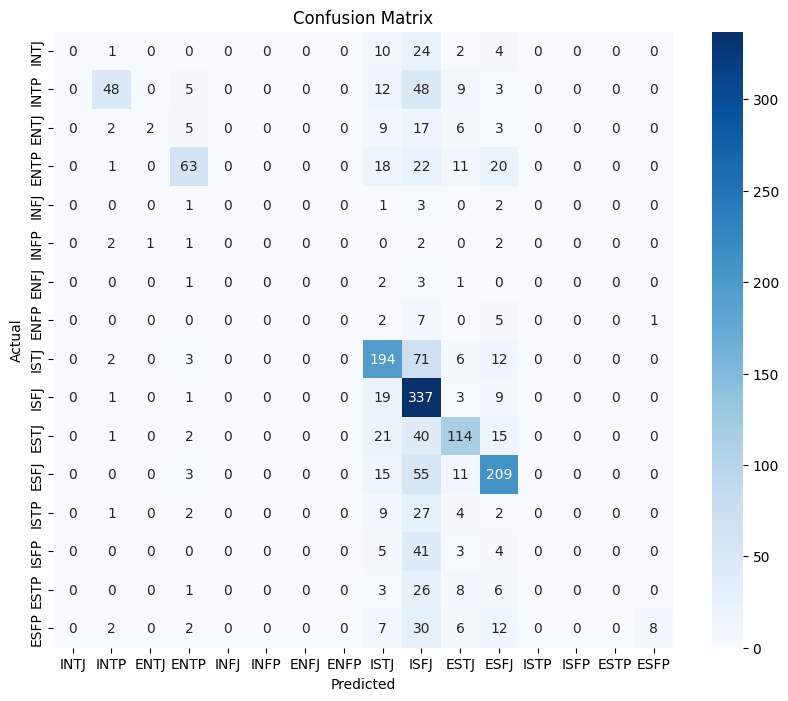

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate a confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)

# Define MBTI types for labeling the matrix
mbti_types = ['INTJ', 'INTP', 'ENTJ', 'ENTP', 
              'INFJ', 'INFP', 'ENFJ', 'ENFP', 
              'ISTJ', 'ISFJ', 'ESTJ', 'ESFJ', 
              'ISTP', 'ISFP', 'ESTP', 'ESFP']

# Display the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=mbti_types, yticklabels=mbti_types)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [46]:
def calculate_letter_off_metrics(actual, predicted):
    letter_off_counts = {i: 0 for i in range(1, 5)}
    incorrect_counts = {i: 0 for i in range(1, 5)}
    incorrect_count = 0

    for act, pred in zip(actual, predicted):
        differences = sum(1 for a, p in zip(act, pred) if a != p)
        
        if 1 <= differences <= 4:
            letter_off_counts[differences] += 1
            if act != pred:
                incorrect_counts[differences] += 1
        
        if act != pred:
            incorrect_count += 1

    total_predictions = len(actual)
    metrics = {
        "Letters Off": [],
        "Percentage of Incorrect": [],
        "Percentage of Total": []
    }

    for i in range(1, 5):
        incorrect_percentage = (incorrect_counts[i] / incorrect_count) * 100 if incorrect_count > 0 else 0
        total_percentage = (letter_off_counts[i] / total_predictions) * 100
        metrics["Letters Off"].append(f"{i} Letter{'s' if i > 1 else ''} Off")
        metrics["Percentage of Incorrect"].append(incorrect_percentage)
        metrics["Percentage of Total"].append(total_percentage)

    return pd.DataFrame(metrics)

# Assuming y_test and predictions are your actual and predicted MBTI types
metrics_df = calculate_letter_off_metrics(y_test, predictions)

# Display the DataFrame without the index
print(metrics_df.to_string(index=False))


  Letters Off  Percentage of Incorrect  Percentage of Total
 1 Letter Off                50.000000            21.902017
2 Letters Off                34.342105            15.043228
3 Letters Off                14.473684             6.340058
4 Letters Off                 1.184211             0.518732


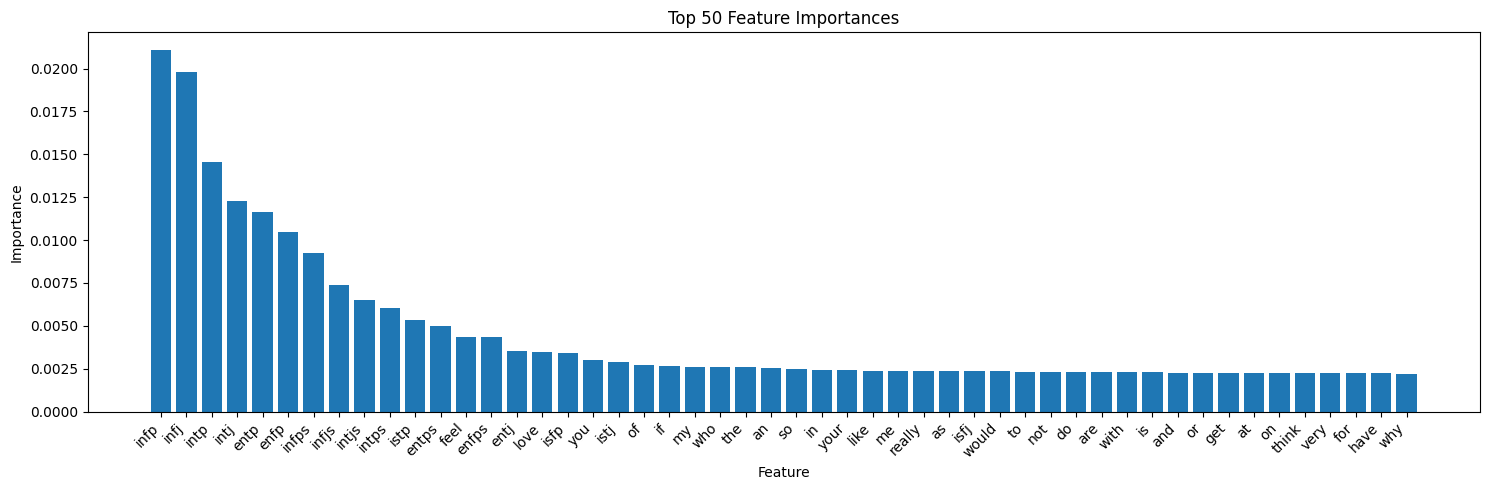

In [41]:
import matplotlib.pyplot as plt

# Get feature importances
feature_importances = random_forest_model.feature_importances_
feature_names = tfidf_vectorizer.get_feature_names_out()

# Sort the feature importances in descending order and get the indices
sorted_indices = feature_importances.argsort()[::-1]

# Number of top features to display
top_n = 50  # You can adjust this number

# Create a figure
plt.figure(figsize=(15, 5))
plt.title("Top {} Feature Importances".format(top_n))
plt.bar(range(top_n), feature_importances[sorted_indices[:top_n]], align='center')

# Set the x-ticks to be the feature names
plt.xticks(range(top_n), [feature_names[i] for i in sorted_indices[:top_n]], rotation=45, ha='right')
plt.xlabel('Feature')
plt.ylabel('Importance')

# Display the plot
plt.tight_layout()  # Adjusts the plot to ensure everything fits without overlapping
plt.show()


In [60]:
def preprocess_and_predict_probabilities(input_text, tfidf_vectorizer, model, classes):
    # Preprocess the text (ensure this matches your training preprocessing)
    def preprocess_text(text):
        text = text.lower()  # Lowercasing
        # Add other preprocessing steps here
        return text

    # Preprocess the input text
    processed_text = preprocess_text(input_text)

    # Vectorize the preprocessed text
    vectorized_text = tfidf_vectorizer.transform([processed_text])

    # Get class probabilities
    probabilities = model.predict_proba(vectorized_text)

    # Create a dictionary mapping class labels to probabilities
    probability_dict = {cls: prob for cls, prob in zip(classes, probabilities[0])}

    # Sort the dictionary by probability in descending order
    sorted_probability_dict = dict(sorted(probability_dict.items(), key=lambda item: item[1], reverse=True))

    return sorted_probability_dict

# Example usage
input_text = "Your sample text here" #TEXT HERE
classes = random_forest_model.classes_  # Get class labels (MBTI types) from the model
sorted_probabilities = preprocess_and_predict_probabilities(input_text, tfidf_vectorizer, random_forest_model, classes)

# Print the sorted probabilities for each class
for mbti_type, prob in sorted_probabilities.items():
    print(f"{mbti_type}: {prob:.2f}")


INFP: 0.25
INTJ: 0.14
INTP: 0.12
INFJ: 0.11
ISFP: 0.07
ISFJ: 0.07
ENFP: 0.05
ISTJ: 0.04
ENTJ: 0.03
ENTP: 0.03
ISTP: 0.02
ESTP: 0.01
ENFJ: 0.01
ESFP: 0.01
ESTJ: 0.01
ESFJ: 0.00
